<a href="https://colab.research.google.com/github/lddm/ml-journey/blob/main/Planet_Amazon_challenge_Learning_rate_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
This notebook implements a solution for the Kaggle Planet: [Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) challenge by finetunning a ResNet50 previously trained in ImageNet. 

Sections and code are ordered in a way that should be easy to follow, if you have doubts or comments please do not hesitate in reaching me by opening an issue in my ml-journey repository: https://github.com/lddm/ml-journey  

I use this notebook for both training and applying the classifier for the challenge. The latest state of the notebook in github may not have all cells' outputs. If you have doubts about some output you can always try running the notebook end-to-end on your own or ask me, I would be happy to help.

# Environment setup

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

%matplotlib inline

# Imports
import os
import time
import copy
import cv2
import torch
import torchvision
import math
import pickle

import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from PIL import Image
from tqdm import tqdm
from google.colab import drive, files
from sklearn import metrics

from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Constants
TRAIN_DIR = 'train/train-jpg'
TEST_DIR = 'test/test-jpg'
ROOT_PATH = '/content/gdrive/MyDrive/planet_amazon'
MODEL_PATH = os.path.join(ROOT_PATH, 'planet_challenge_model_one_cycle_lr.tar')
TRAINING_BATCH_SIZE = 32
TRAINING_EPOCHS = 5
SUBMISSION_FILENAME = 'submission_one_cycle_lr.csv'

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
drive.mount('/content/gdrive')
os.chdir(ROOT_PATH)

Mounted at /content/gdrive


### Uncompress data
Only need to run once to extract the compressed archives into folders suitable for training and classification.

In [3]:
# root_path = '/content/gdrive/MyDrive/planet_amazon'
# os.getcwd()
# os.chdir(root_path)  #change dir
# !mkdir train  #create a directory named train/
# !mkdir test  #create a directory named test/
# !tar -xvf  'train-jpg.tar' -C 'train'
# !tar -xvf  'test-jpg-all-images.tar.gz' -C 'test'

# Auxiliary functions

In [8]:
def get_items(df):
    return df
    # Grab subset of items
    # return df.sample(n=64*30, random_state=891237)

def get_x(df_row):
    img_name = df_row['image_name']
    img_path = os.path.join(TRAIN_DIR, f'{img_name}.jpg')
    return img_path

def get_y(df_row):
    return df_row['tags'].split(' ')

def imshow(inp, fig_size=4, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    ax.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def initialize_resnet(num_classes, use_pretrained=True):
    model = models.resnet50(pretrained=use_pretrained)
    # Adjust last fully connected layer to number of classes in the PlanetAmazonChallenge
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Based on https://www.kaggle.com/igormq/f-beta-score-for-pytorch
def f2_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 2, threshold)


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(y_pred.float(), threshold).float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))

# Based on https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
# Allows obtaining image paths when iterating by batches using the DataLoader
# Code is modified to only return the file name, without path and without 
# extension, thus generating the output format expected by the Kaggle 
# competition
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        img_path = self.imgs[index][0]
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (img_name,))
        return tuple_with_path

# One-cycle learning rate policy
The One-Cycle Policy for finding a optimal learning rate has shown good results in the Kaggle competition. The underlying idea behind this strategy is that too low learning rates requires many updates for reaching the minimum loss point and make the difficult to pass saddle points while training. On the other hand, too high learning rates can lead to divergence as the gradient descent fails to move towards a minimum in the loss surface. This is shown clearly in the following two images.  
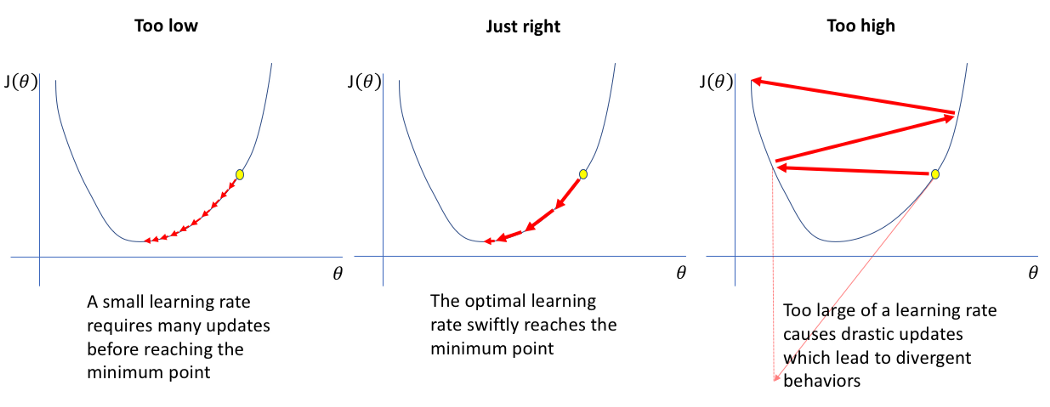

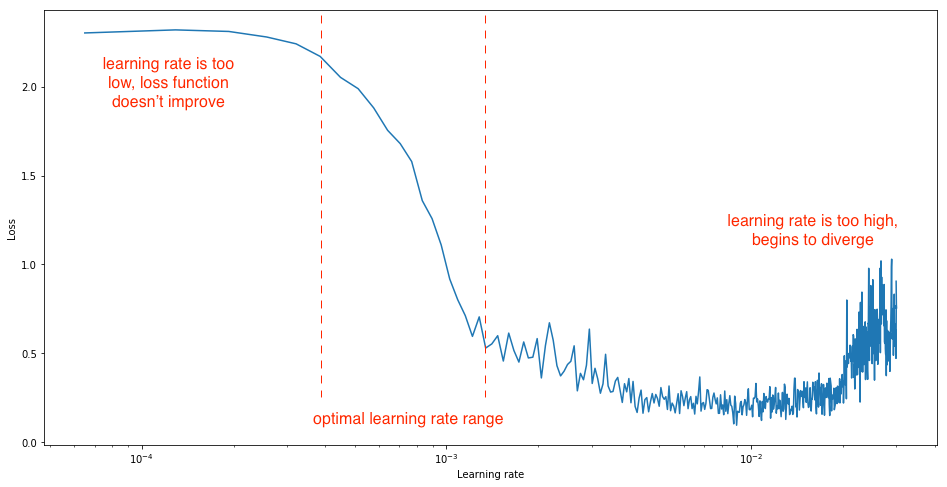

This One-Cycle-Policy is very clearly explained in the following article: https://medium.com/dsnet/the-1-cycle-policy-an-experiment-that-vanished-the-struggle-in-training-neural-nets-184417de23b9  

Links to the papers in which this article is based can be found below:
* http://arxiv.org/abs/1506.01186
* https://arxiv.org/abs/1708.07120
* https://arxiv.org/abs/1803.09820

Code used here is adapted from code in the following repo: https://github.com/nachiket273/One_Cycle_Policy

## Auxiliary functions

In [15]:
class CLR():
    def __init__(self, train_dataloader, base_lr=1e-5, max_lr=100):
        self.base_lr = base_lr # The lower boundary for learning rate (initial lr)
        self.max_lr = max_lr # The upper boundary for learning rate
        self.bn = len(train_dataloader) - 1 # Total number of iterations used for this test run (lr is calculated based on this)
        ratio = self.max_lr/self.base_lr # n
        self.mult = ratio ** (1/self.bn) # q = (max_lr/init_lr)^(1/n)
        self.best_loss = 1e9 # our assumed best loss
        self.iteration = 0 # current iteration, initialized to 0
        self.lrs = []
        self.losses = []
        
    def calc_lr(self, loss):
        self.iteration +=1
        if math.isnan(loss) or loss > 4 * self.best_loss: # stopping criteria (if current loss > 4*best loss) 
            return -1
        if loss < self.best_loss and self.iteration > 1: # if current_loss < best_loss, replace best_loss with current_loss
            self.best_loss = loss
        mult = self.mult ** self.iteration # q = q^i
        lr = self.base_lr * mult # lr_i = init_lr * q
        self.lrs.append(lr) # append the learing rate to lrs
        self.losses.append(loss) # append the loss to losses
        return lr
        
    def plot(self, start=10, end=-5): # plot lrs vs losses
        plt.xlabel("Learning Rate")
        plt.ylabel("Losses")
        plt.plot(self.lrs[start:end], self.losses[start:end])
        plt.xscale('log') # learning rates are in log scale
      
    def save(self, path):
      pickle.dump(self, open(path, "wb"))

    @classmethod
    def load(cls, path):
      return pickle.load(open(path, "rb"))

## LR-range test

In [6]:
def find_lr(clr, model, dataloader, loss_func, opt, clr_save_path=None):
    running_loss = 0. 
    avg_beta = 0.98 # useful in calculating smoothed loss
    threshold = 0.2
    model.train() # set the model in training mode

    with tqdm(dataloader, unit="mini-batch") as training_batch:
      for i, (inputs, labels) in enumerate(training_batch):
        # move the inputs and labels to gpu if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs) # predict output
        preds = outputs > threshold
        loss = loss_func(outputs, labels) # calculate loss 
        
        # calculate the smoothed loss 
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss # the running loss
        smoothed_loss = running_loss / (1 - avg_beta**(i+1)) # smoothening effect of the loss 
        
        lr = clr.calc_lr(smoothed_loss) # calculate learning rate using CLR
        if lr == -1 : # the stopping criteria
            break
        for pg in opt.param_groups: # update learning rate
            pg['lr'] = lr   

        # compute gradient and do parameter updates
        opt.zero_grad()
        loss.backward()
        opt.step()

        if clr_save_path:
          clr.save(clr_save_path)

In [7]:
model = initialize_resnet(len(train_dataset.mlb.classes_), use_pretrained=True)
model = model.to(device)

loss_func = nn.BCEWithLogitsLoss() # loss function
opt = optim.SGD(model.parameters(), lr=1e-4, momentum=0.95) # optimizer
clr = CLR(train_loader, max_lr=1) # CLR instance
clr_pickle_path = 'clr_test.bin'

find_lr(clr, model, train_loader, loss_func, opt, clr_pickle_path)

NameError: ignored

In [ ]:
clr.plot(0, -1)

In [ ]:
os.listdir()
clr_test = CLR.load(clr_pickle_path)

## Training based on the One-cycle policy

In [17]:
class OneCycle():
    def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt= 10 , div=10):
        self.nb = nb # total number of iterations including all epochs
        self.div = div # the division factor used to get lower boundary of learning rate
        self.step_len =  int(self.nb * (1- prcnt/100)/2)
        self.high_lr = max_lr # the optimum learning rate, found from LR range test
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.prcnt = prcnt # percentage of cycle length,we annihilate learning rate below the lower learnig rate (default is 10)
        self.iteration = 0
        self.lrs = []
        self.moms = []
        
    def calc(self): # calculates learning rate and momentum for the batch
        self.iteration += 1
        lr = self.calc_lr()
        mom = self.calc_mom()
        return (lr, mom)
        
    def calc_lr(self):
        if self.iteration==self.nb: # exactly at `d`
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        if self.iteration > 2 * self.step_len: # case c-d
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
            lr = self.high_lr * (1 - ratio * (1-(1/self.div)))/self.div
        elif self.iteration > self.step_len: # case b-c
            ratio = 1- (self.iteration -self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else : # case a-b
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr
    
    def calc_mom(self):
        if self.iteration==self.nb: # exactly at `d`
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        if self.iteration > 2 * self.step_len: # case c-d
            mom = self.high_mom
        elif self.iteration > self.step_len: # case b-c 
            ratio = (self.iteration -self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else : # case a-b
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom


def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

# Train the network

### Test access to training data

In [10]:
train_df = pd.read_csv('train_v2.csv')
train_img_path = get_x(train_df.loc[0])
print(train_img_path)
tags = get_y(train_df.loc[0])
print(tags)

train_img = cv2.imread(train_img_path)
train_img.shape

train/train-jpg/train_0.jpg
['haze', 'primary']


(256, 256, 3)

### Load training data 

### Handle dataset particular structure

The [torchvision.datasets](https://pytorch.org/vision/0.8/datasets.html#torchvision-datasets) class expects a specific structure for the data and their corresponding labels, e.g: 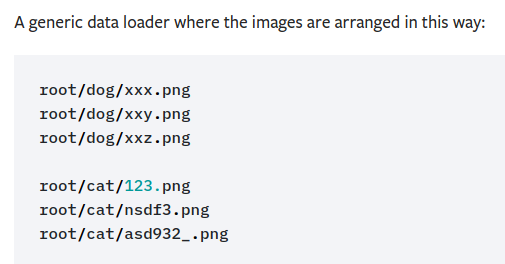

This is not very convenient for handling how data is provided in the Kaggle _Understanding the Amazon from Space_ challenge. This is easily fixable by implementing a custom sub-class of the torch Dataset class. Code below is based on https://www.kaggle.com/mratsim/starting-kit-for-pytorch-deep-learning#Loading-the-data---first-part---DataSet  

The implemented `KaggleAmazonDataset` makes use of [sklearn.preprocessing.MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html#sklearn-preprocessing-multilabelbinarizer) to encode the categorical labels in a convenient numerical format for the training.

In [11]:
class KaggleAmazonDataset(Dataset):
    """Dataset wrapping images and target labels for Kaggle - Planet Amazon from Space competition.

    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
        Transform (optional) object containing transformations to apply on imagery.
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None, number_samples=None):
    
        self.tmp_df = pd.read_csv(csv_path)
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform
        
        self._check_corrupt_files()

        image_names = self.tmp_df['image_name']
        tags = self.tmp_df['tags']
        if number_samples:
          image_names = image_names[:number_samples]
          tags = tags[:number_samples]
          self.dataset_size = number_samples
        else:
          self.dataset_size = len(image_names)

        self.X_train = image_names
        # self.y_train is a sparse-matrix of size num_samples x num_classes where an element [i,j] equals 1 
        # iff the sample with index 'i' correspond to class 'j'
        self.y_train = self.mlb.fit_transform(tags.str.split()).astype(np.float32)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.X_train[index] + 
                                      self.img_ext))
        img = img.convert('RGB')
        if self.transform is not None:
          img = self.transform(img)

        label = torch.from_numpy(self.y_train[index])
        return img, label
    
    def _check_corrupt_files(self):
        # check that all images listed in the train.csv are available on the training folder
        assert self.tmp_df['image_name'].apply(lambda x: os.path.isfile(os.path.join(
                self.img_path, x + self.img_ext))).all(), \
"Some images referenced in the CSV file were not found"
        
        # some files available in the folder are corrupted causing an PIL.UnidentifiedImageError
        for image_name in self.tmp_df['image_name']:
          file_size = os.stat(os.path.join(
              self.img_path, image_name + self.img_ext)).st_size
          if file_size == 0:
            raise(OSError('File {} is corrupt'.format(image_name)))
        
    
    def decode_binary_label(self, array):
      return self.mlb.inverse_transform(array)

    def __len__(self):
        return len(self.X_train.index)

In [12]:
print('Train dataset size: ', len([name for name in os.listdir(TRAIN_DIR) if os.path.isfile(os.path.join(TRAIN_DIR, name))]))
# the parameters used here are based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      # Normalization mean and std. dev. 
                                      # factors are taken from ImageNet
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])])

train_dataset = KaggleAmazonDataset('train_v2.csv', TRAIN_DIR, '.jpg', 
                                    data_transforms)

train_loader = DataLoader(train_dataset,
                          batch_size=TRAINING_BATCH_SIZE,
                          shuffle=True,
                          num_workers=1, # 1 for CUDA
                          pin_memory=True # CUDA only
                         )

dataset_sizes = {'train': train_dataset.dataset_size}

Train dataset size:  40479


### Test train_loader and classes decoding

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

imshow(out, fig_size=20)

train_dataset.decode_binary_label(classes)

### Finetunning the network

In [13]:
def train_model(model, criterion, optimizer, scheduler, one_cycle=None, 
                last_epoch=0, num_epochs=25, save_model=False, threshold=0, 
                epoch_loss_evolution=[], epoch_acc_evolution=[]):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    if epoch_acc_evolution:
      best_acc = max(epoch_acc_evolution)
    else:
      best_acc = 0.0

    for epoch in range(last_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                if one_cycle:
                  lr, mom = one_cycle.calc()
                  update_lr(optimizer, lr)
                  update_mom(optimizer, mom)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = outputs > threshold
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # print('f2beta score: ', fbeta_score(labels.data, preds, 2, 0.2))
            if phase == 'train' and one_cycle is None:
                scheduler.step()

            epoch_loss_evolution.append(running_loss / dataset_sizes[phase])
            
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc_evolution.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss_evolution[-1], epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_model:
                  torch.save({
                      'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss_evolution': epoch_loss_evolution,
                      'accuracy_evolution': epoch_acc_evolution
                      }, MODEL_PATH)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
model = initialize_resnet(len(train_dataset.mlb.classes_), use_pretrained=True)
model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# Loss selected for multi-label classification problem based on https://discuss.pytorch.org/t/multi-label-classification-in-pytorch/905/45
criterion = nn.BCEWithLogitsLoss()

# Observe that all parameters are being optimized
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-7)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Decay LR by a factor of 0.1 every 8 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

# Initialize OneCycle object
number_iterations = TRAINING_EPOCHS * TRAINING_BATCH_SIZE
one_cycle = OneCycle(number_iterations, max_lr=1e-1)

In [19]:
load_model = False
if load_model:
  checkpoint = torch.load(MODEL_PATH)

  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  last_epoch = checkpoint['epoch']
  epoch_loss_evolution = checkpoint['loss_evolution']
  epoch_acc_evolution = checkpoint['accuracy_evolution']
else:
  epoch_loss_evolution = []
  epoch_acc_evolution = []
  last_epoch = 0

IndexError: ignored

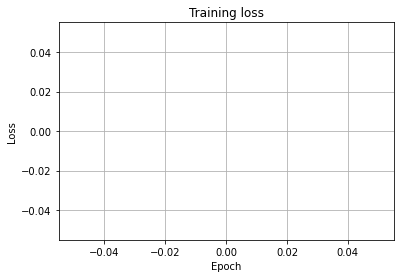

In [20]:
plt.plot(epoch_loss_evolution)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

print('Last loss: {}'.format(epoch_loss_evolution[-1]))

In [21]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, one_cycle,
                    last_epoch=last_epoch, num_epochs=TRAINING_EPOCHS, save_model=True, 
                    threshold=0.2, epoch_loss_evolution=epoch_loss_evolution, 
                    epoch_acc_evolution = epoch_acc_evolution)

Epoch 0/4
----------
train Loss: 0.1236 Acc: 16.2182

Epoch 1/4
----------
train Loss: 0.0988 Acc: 16.3601

Epoch 2/4
----------
train Loss: 0.0911 Acc: 16.4067

Epoch 3/4
----------
train Loss: 0.0848 Acc: 16.4409

Epoch 4/4
----------
train Loss: 0.0783 Acc: 16.4858

Training complete in 189m 17s
Best train Acc: 16.485832


# Classify test images

## Load model

In [22]:
model = initialize_resnet(len(train_dataset.mlb.classes_))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
epoch_loss_evolution = checkpoint['loss_evolution']

## Load and classify by batch

In [24]:
print('Test dataset size: ', len([name for name in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, name))]))
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset = {'test' : ImageFolderWithPaths('test', test_transforms)}
dataloader = {'test': torch.utils.data.DataLoader(dataset['test'], batch_size = 250, shuffle=False, num_workers=2)}

Test dataset size:  61191


In [25]:
print(len(dataloader['test'].dataset)) 


61191


In [27]:
def classify(model, dataloader, multi_label_binarizer, show_images=False, threshold=0):
    was_training = model.training
    model.eval()
    results_df = pd.DataFrame(columns=['image_name','tags'])
    with tqdm(dataloader, unit="batch") as classification_batch:
      for inputs, _, img_names in classification_batch:
        with torch.no_grad():
          inputs = inputs.to(device)
          outputs = model(inputs)
          preds = outputs > threshold
          # recover categorical labels from binary predictions
          labels = multi_label_binarizer.inverse_transform(preds.cpu())

          #labels is a list of size classification batch where each element 
          # is a tuple with the labels corresponding to each image. The 
          # submission expects the labels of each image to be outputted as a 
          # space separated list
          output_labels = [' '.join(labels) for labels in labels]
          
          results_df = results_df.append(pd.DataFrame({
              'image_name': img_names,
              'tags': output_labels
          }))

          if show_images:
            fig = plt.figure(figsize=(10, 10))
            print('Labels: ', labels)
            imshow(inputs.squeeze(0).cpu().data)
    
    model.train(mode=was_training)
    return results_df

In [28]:
results_df = classify(model, dataloader['test'], train_dataset.mlb, show_images=False, threshold=0.2)

100%|██████████| 245/245 [1:27:56<00:00, 21.53s/batch]


In [31]:
results_df.to_csv(SUBMISSION_FILENAME, index=False)

# Submitting results to Kaggle competition
* Instructions on how to use Kaggle API from Google Colab environment can be found [here](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb)
* Details on the format of the output that should be submitted as well as the Kaggle API command that should be used can be found [here](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/submit)


In [32]:
results_df = pd.read_csv(SUBMISSION_FILENAME)

In [33]:
results_df

,image_name,tags
0,file_0,clear primary
1,file_1,agriculture clear habitation primary road
2,file_10,haze primary road water
3,file_100,clear primary water
4,file_1000,clear primary
...,...,...
61186,test_9995,clear primary
61187,test_9996,partly_cloudy primary
61188,test_9997,agriculture cultivation partly_cloudy primary
61189,test_9998,clear primary


In [34]:
!pip install kaggle

In [5]:


uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [8]:
print(SUBMISSION_FILENAME)
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f submission_one_cycle_lr.csv -m "Second iteration results using transfer learning with a ResNet50 trained in ImageNet and One Cycle policy"


submission_one_cycle_lr.csv
100% 1.94M/1.94M [00:00<00:00, 2.35MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space